In [1]:
%load_ext autoreload
%autoreload 2
from storytelling import *

In [2]:
# select en events:
events = pd.read_csv("../dat/tweeterNews/events.csv.gz", header=None,
                     names=["Num","Date","TotalKeyWords","TotalTweets","Keywoards"])

In [3]:
events.sort_values("TotalTweets", ascending=False).head(10)

,Num,Date,TotalKeyWords,TotalTweets,Keywoards
4498,4499,2014-05-28,9,510920,angelou;pakistan;life;woman;maya;risk;dies;dea...
4883,4884,2014-06-12,22,452534,turtle;sao;win;national;follow;home;brazil;pol...
231,232,2013-09-10,32,423756,control;says;apple;december;india;four;gang;fo...
1965,1966,2014-02-02,10,338252,fans;bowl;see;sunday;blog;game;security;xlviii...
1977,1978,2014-02-03,16,313030,broncos;super;title;may;win;million;bowl;blog;...
1257,1258,2013-12-31,25,308703,celebrations;photo;globe;tonight;australia;yea...
1860,1861,2014-01-29,18,301448,boy;grimm;end;unemployment;veto;rep;reporter;y...
1737,1738,2014-01-23,13,281559,prime;ukraine;supreme;resisting;police;justin;...
1688,1689,2014-01-20,2,276219,king;luther
2701,2702,2014-03-08,35,271306,spotted;hairline;photo;slicks;airlines;malaysi...


In [4]:
events.loc[4883, "Keywords"]

KeyError: 'the label [Keywords] is not in the [index]'

In [8]:
tweets = pd.read_csv("../dat/tweeterNews/tweets.csv.gz", names=["tid", "eid"])

In [9]:
tweets.head()

,tid,eid
0,371043469185540096,1
1,371043472397987841,1
2,371043478404222976,1
3,371043500814385152,1
4,371043512642719744,1


In [10]:
wildfire_yosemite = tweets[tweets["eid"]==5]

In [11]:
wildfire_yosemite.head()

,tid,eid
27927,370581177494941696,5
27928,370581180321910784,5
27929,370581197103300608,5
27930,370581385456545792,5
27931,370581492789153792,5


In [12]:
tids = list(wildfire_yosemite["tid"].values)
len(tids)

12488

In [13]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth)

In [14]:
writer = csv.writer(open("dat/wildfire_yosemite.csv", "wt"))
header = ["id", "text", "created_at", "retweet_count", "user_id", "user_followers_count",
          "rt_id", "rt_text", "rt_created_at", "rt_retweet_count", "rt_user_id", "rt_user_followers_count"]
writer.writerow(header)

143

In [15]:
i = 0; j = 100
while 1:
    tweet = api.statuses_lookup(tids[i:j])
    Tweets2CSV(tweet, writer)
    i += 100;
    j += 100;
    if j > len(tids):
        break
    if j >= len(tids):
        j = tids

In [16]:
tids.index(477150935882297344)

ValueError: 477150935882297344 is not in list

In [ ]:
len(tids)

In [ ]:
# 4884
event_id = 4884
event_tweets = tweets[tweets["eid"]==4884]
tids = list(event_tweets["tid"].values)
RetriveDataset(tids, api, "4884.csv")

In [ ]:
# 4499
event_id = 4499
event_tweets = tweets[tweets["eid"]==event_id]
tids = list(event_tweets["tid"].values)
RetriveDataset(tids, api, "{}.csv".format(event_id))

In [ ]:
# 232
event_id = 232
event_tweets = tweets[tweets["eid"]==event_id]
tids = list(event_tweets["tid"].values)
RetriveDataset(tids, api, "{}.csv".format(event_id))

In [4]:
yesemite = "/Users/jiayao/Work/Storytelling/src/dat/wildfire_yosemite.csv"
df = pd.read_csv(yesemite)

In [5]:
df.head(2)

,id,text,created_at,retweet_count,user_id,user_followers_count,rt_id,rt_text,rt_created_at,rt_retweet_count,rt_user_id,rt_user_followers_count
0,370586020070563841,RT @AP: Wildfire near Yosemite more than tripl...,Thu Aug 22 16:39:27 +0000 2013,74,141529750,5605,3.705746e+17,Wildfire near Yosemite more than triples in si...,Thu Aug 22 15:54:02 +0000 2013,74.0,51241574.0,13803375.0
1,370607666386579457,RT @DRUDGE_REPORT: Yosemite wildfire balloons ...,Thu Aug 22 18:05:27 +0000 2013,13,20715638,3786,3.706056e+17,Yosemite wildfire balloons to 84 square miles ...,Thu Aug 22 17:57:05 +0000 2013,13.0,14669951.0,1326626.0


In [6]:
df.shape

(5314, 12)

In [7]:
DC = TwitterCleaner()

In [8]:
Data = []
for i in range(df.shape[0]):
    Data.append(DC.Clean(df.loc[i, "text"]))

In [9]:
DC.corpusWC(Data, "yosemite.1gram.wc.txt")

In [10]:
vocabularies = pd.read_csv("yosemite.1gram.wc.txt", names=["Word", "Count"], delimiter="\t")["Word"].values[:200]
#vocabularies
BW = DC.BagOfWords(Data, vocabularies)

In [11]:
BW

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

(5314, 40)


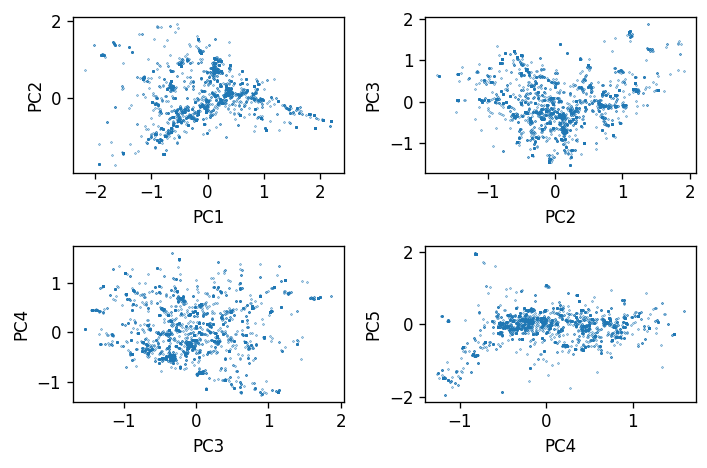

In [12]:
pca = PCA(n_components=40, svd_solver='arpack')
X = pca.fit_transform(BW)
print(X.shape)
fig, axs = plt.subplots(2,2,dpi=120)
for i,(j,k) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axs[j,k].scatter(X[:,i], X[:,i+1], s=0.1)
    axs[j,k].set_xlabel("PC%d"%(i+1))
    axs[j,k].set_ylabel("PC%d"%(i+2))
fig.tight_layout()
plt.show()

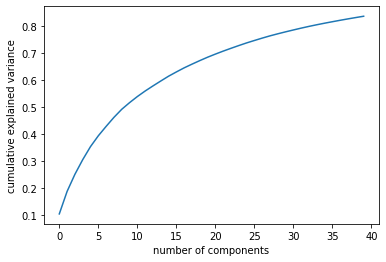

In [13]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [14]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(X[:, :40])

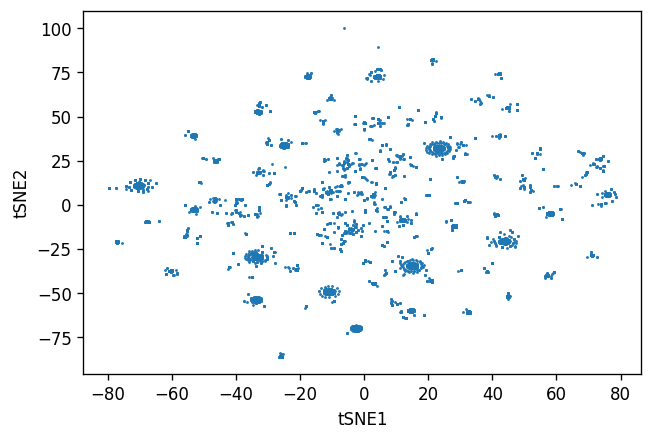

In [15]:
fig = plt.figure(dpi=120)
ax = plt.subplot(111)
ax.scatter(Y[:,0], Y[:,1],s=0.5)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.show()

In [16]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(Y)
groups = AssignCluster(Y, clusters)
centers = kmeans.cluster_centers_ 

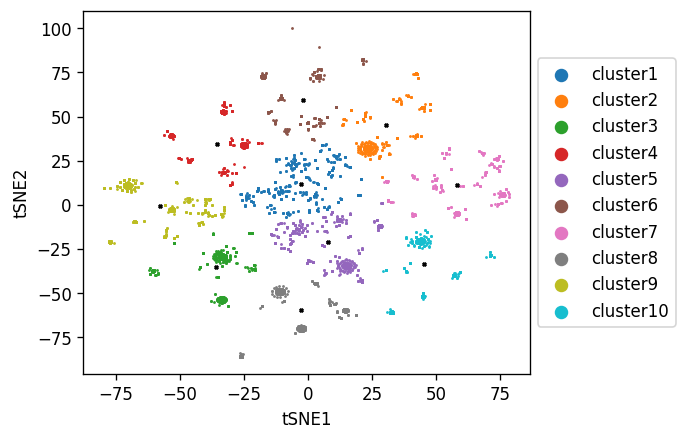

In [17]:
fig = plt.figure(dpi=120)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.show()

In [18]:
Agg = sklearn.cluster.AgglomerativeClustering(n_clusters=10)
clusters = Agg.fit_predict(Y)
groups = AssignCluster(Y, clusters)
#centers = kmeans.cluster_centers_ 

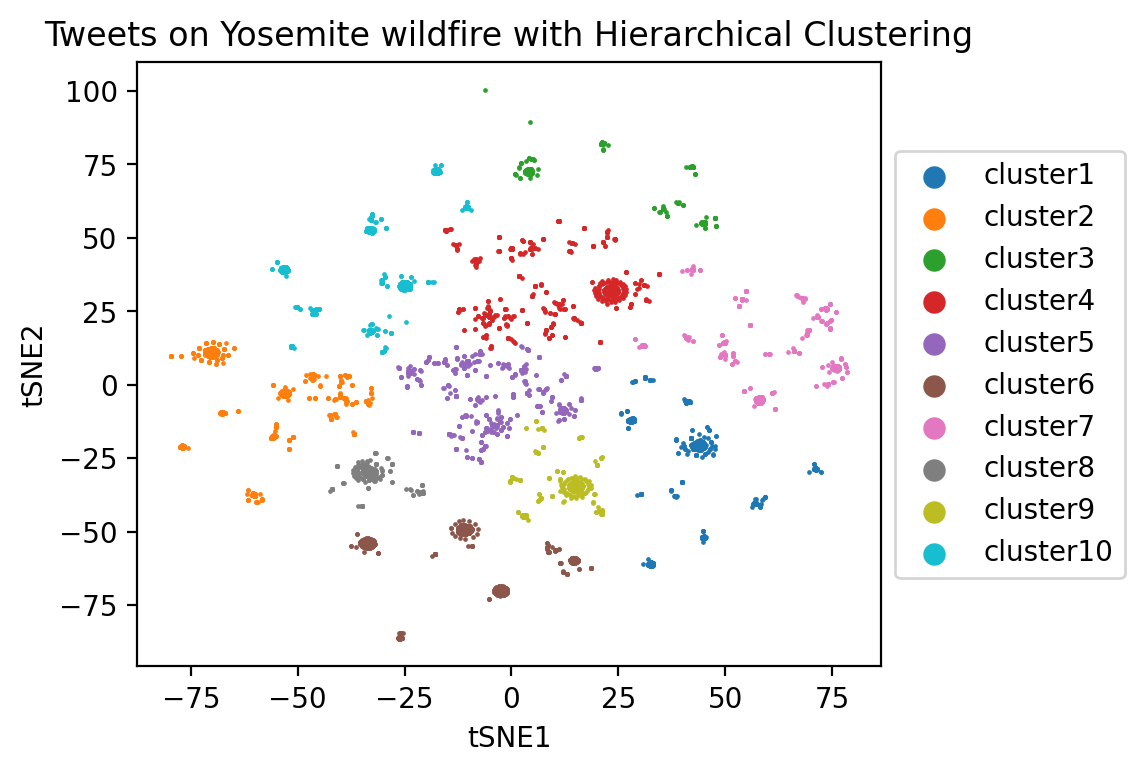

In [19]:
fig = plt.figure(dpi=200)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
#ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.title("Tweets on Yosemite wildfire with Hierarchical Clustering")
plt.show()

In [20]:
Keyinfos = []
for i in range(max(clusters)+1):
    print(i+1)
    topics = np.where(clusters==i)
    #print(topics)
    topics = topics[0]
    info = DC.showTopic(df, topics, Nshow=3)
    Keyinfos.append(info)
    print("-------------")

1
3
Yosemite area wildfire balloons in size overnight http://t.co/oo5SuSGDFT Thu Aug 22 16:45:45 +0000 2013
yosemite area wildfire balloons size overnight

6
#Yosemite-area Wildfire Balloons In Size Overnight: #montereybay # http://t.co/X1VPYAv8yl Thu Aug 22 17:17:22 +0000 2013
yosemite area wildfire balloons size overnight montereybay

7
Yosemite-area wildfire balloons in size overnight.
http://t.co/YuaI92sKTp Thu Aug 22 16:44:21 +0000 2013
yosemite area wildfire balloons size overnight

10
Yosemite-area wildfire balloons in size overnight http://t.co/bZCVEhJ6QM Thu Aug 22 17:56:35 +0000 2013
yosemite area wildfire balloons size overnight

-------------
2
721
BBC News - Wildfire near Yosemite park sends tourists fleeing http://t.co/qB1WUjVoBM Fri Aug 23 03:33:52 +0000 2013
bbc news wildfire near yosemite park sends tourists fleeing

805
BBC News - Wildfire near Yosemite park sends tourists fleeing http://t.co/kE6FI65V98 Fri Aug 23 03:53:28 +0000 2013
bbc news wildfire near yosemite pa

In [21]:
Keyinfos

[id                                                        370587609350684672
 text                       Yosemite area wildfire balloons in size overni...
 created_at                                    Thu Aug 22 16:45:45 +0000 2013
 retweet_count                                                              0
 user_id                                                            513774875
 user_followers_count                                                    3643
 rt_id                                                                    NaN
 rt_text                                                                  NaN
 rt_created_at                                                            NaN
 rt_retweet_count                                                         NaN
 rt_user_id                                                               NaN
 rt_user_followers_count                                                  NaN
 Name: 3, dtype: object,
 id                                    

In [22]:
DC.showTimeline(Keyinfos)

Thu Aug 22 16:39:27 +0000 2013
RT @AP: Wildfire near Yosemite more than triples in size overnight, threatens 2,500 homes, other buidlings: http://t.co/EaLEuVnHvv -DC

Thu Aug 22 16:45:45 +0000 2013
Yosemite area wildfire balloons in size overnight http://t.co/oo5SuSGDFT

Thu Aug 22 17:40:32 +0000 2013
RT @wildfiretoday: #RimFire near #Yosemite NP grows by 37,000 acres. Maps and info at http://t.co/UI8bPzhwVi #wildfire http://t.co/rIGYBMkV…

Thu Aug 22 20:09:01 +0000 2013
RT @ForestryNews: Yosemite National Park Wildfire Continues To Burn With Minimal Destruction http://t.co/At0lwden0V via @HuffPostGreen #sf …

Thu Aug 22 22:24:26 +0000 2013
Hoping @YosemiteNPS and nearby communities find relief soon from the awful, destructive wildfire http://t.co/osFIGbi8sr

Thu Aug 22 22:48:36 +0000 2013
RT @gosiawozniacka: Jerry Brown declares state of emergency for large, growing wildfire near Yosemite National Park http://t.co/tPE3FmmuHc

Fri Aug 23 02:17:17 +0000 2013
#UCWRadio  Wildfire Near Yos

In [50]:
names = [" ".join(DC.Clean(x["text"])) for x in Keyinfos]
dates = [x["created_at"] for x in Keyinfos]
# Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, '%a %b %d %X %z %Y') for d in dates]

In [51]:
dates = [d.strftime("%m-%d-%X") for d in dates]
dates

['08-22-16:45:45',
 '08-23-03:33:52',
 '08-22-22:48:36',
 '08-23-13:21:29',
 '08-22-20:09:01',
 '08-22-17:40:32',
 '08-23-03:09:27',
 '08-22-16:39:27',
 '08-23-02:17:17',
 '08-22-22:24:26']

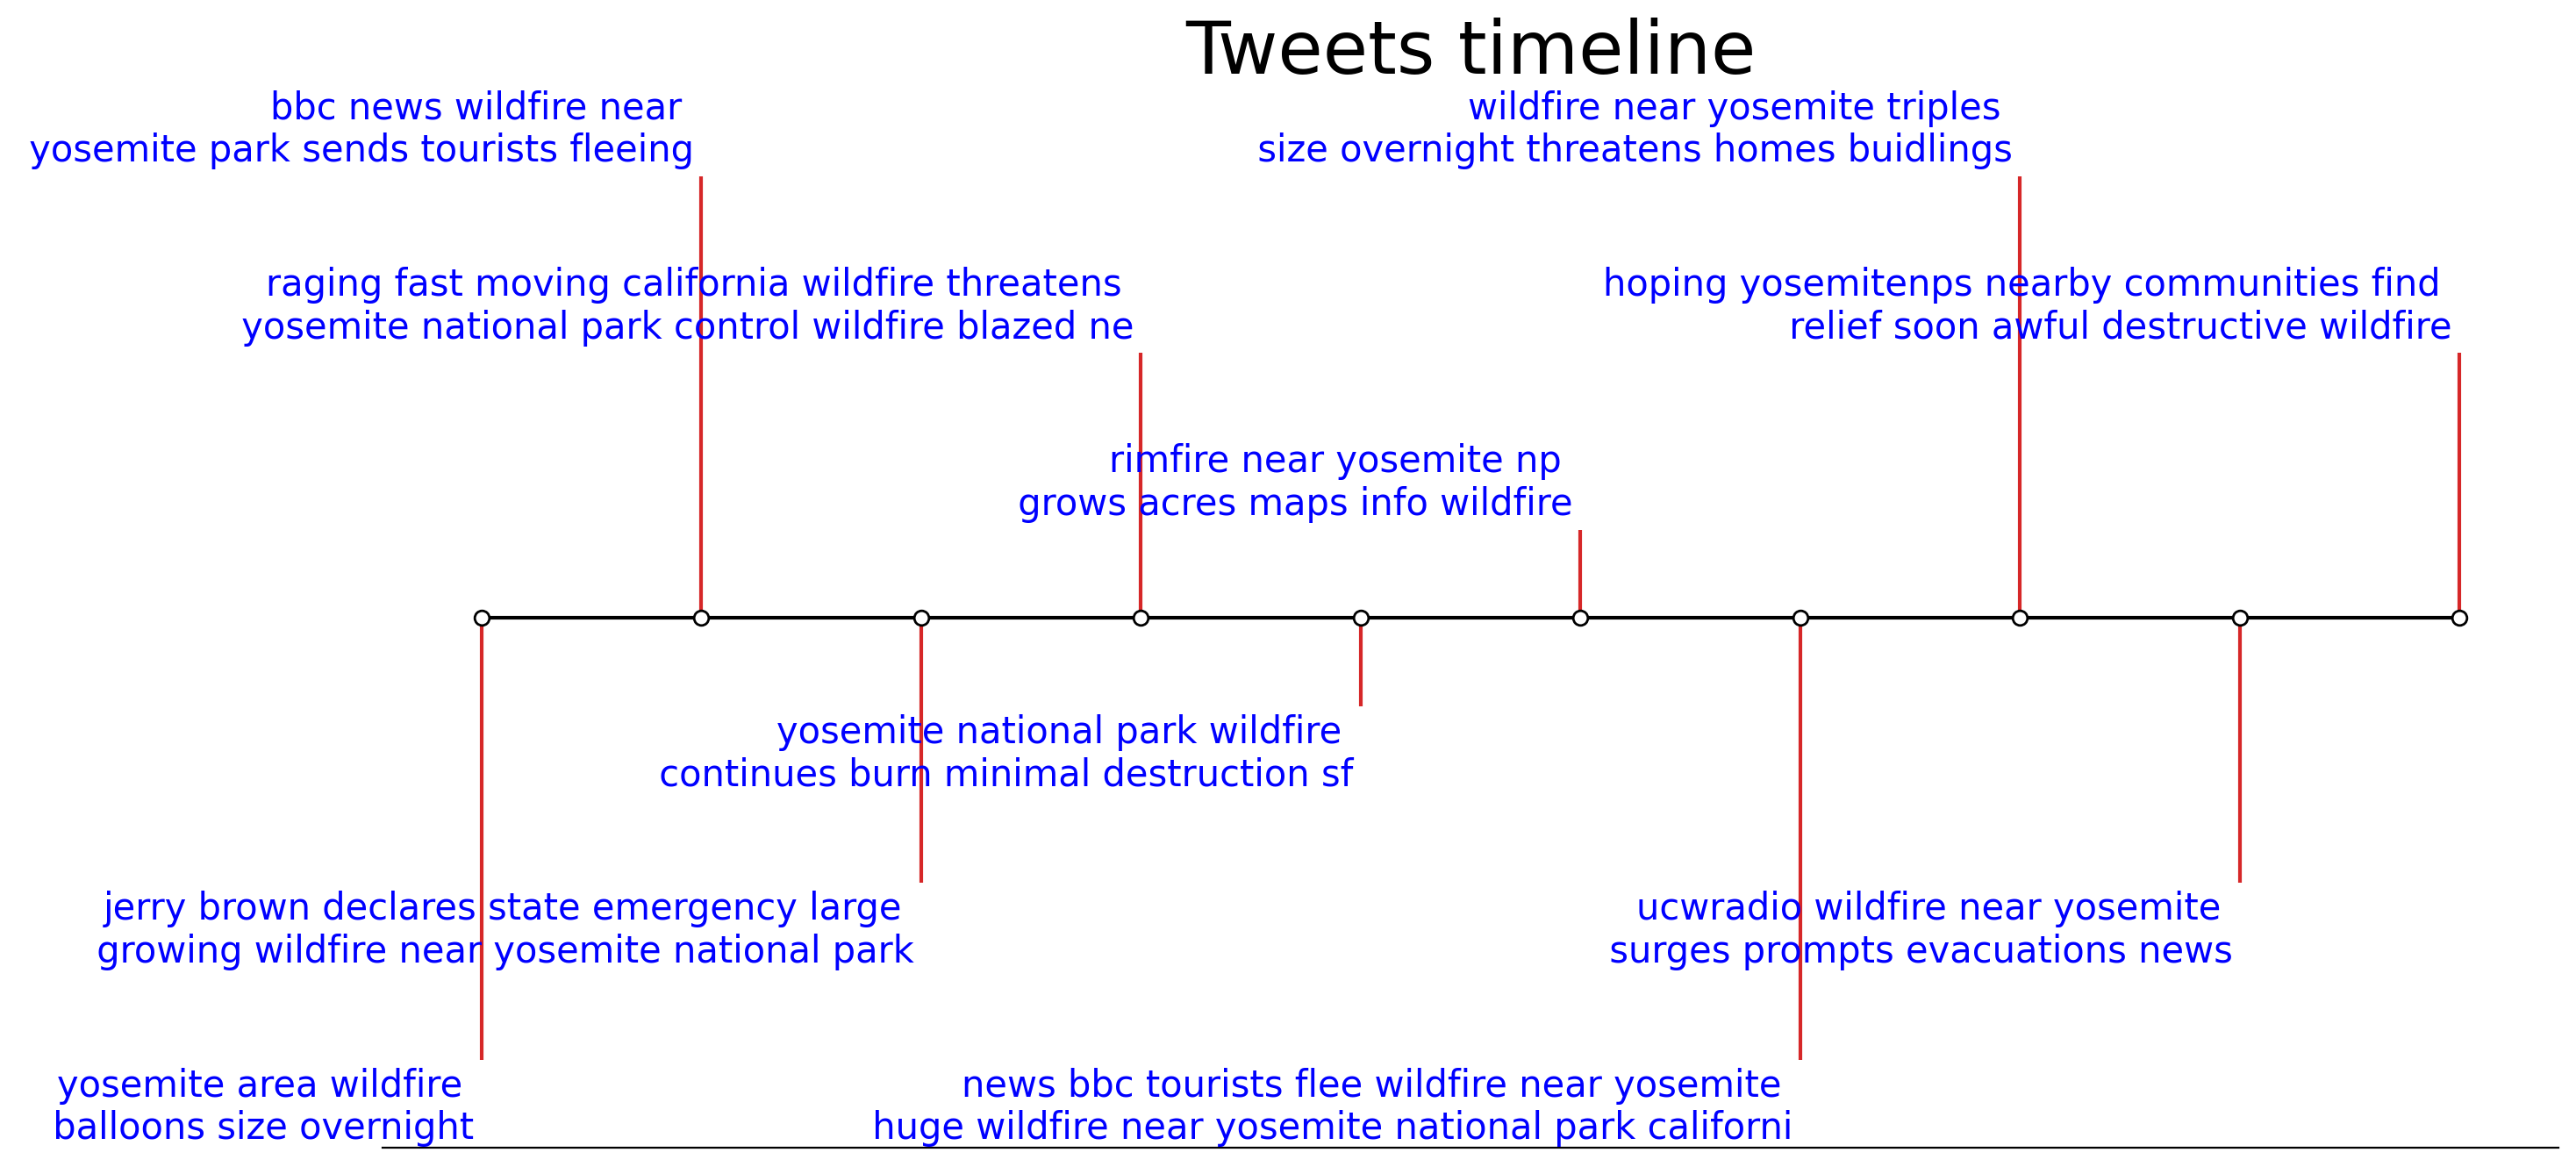

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(16,8), dpi=200)
#ax.set(title=, 
ax.set_title("Tweets timeline", fontsize=30)
markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, names, vert):
    rs = r.split()
    half = int(len(rs)/2)
    r = rs[:half] + ["\n"] + rs[half:]
    r = " ".join(r)
    #print(r)
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right", fontsize=15, color="blue")

# format xaxis with 4 month intervals
ax.get_xaxis().set_major_locator(mdates.HourLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%d %X"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [ ]:
plt.subplots(1,1)

In [ ]:
topic1 = DC.sliceTopic(Y, (-75, -50), (-10, 10))
DC.showTopic(df, topic1)

In [ ]:
topic2 = DC.sliceTopic(Y, (-20, 0), (-50, -30))
DC.showTopic(df, topic2)

In [ ]:
topic2 = DC.sliceTopic(Y, (25, 50), (10, 30))
DC.showTopic(df, topic2)

In [ ]:
topic2 = DC.sliceTopic(Y, (0, 50), (-30, 20))
DC.showTopic(df, topic2, chooseOne=False)

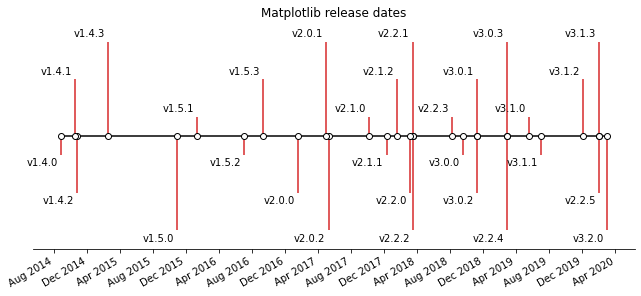

matplotlib.dates.DateFormatter

In [25]:
"""
===============================================
Creating a timeline with lines, dates, and text
===============================================

How to create a simple timeline using Matplotlib release dates.

Timelines can be created with a collection of dates and text. In this example,
we show how to create a simple timeline using the dates for recent releases
of Matplotlib. First, we'll pull the data from GitHub.
"""

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

try:
    # Try to fetch a list of Matplotlib releases and their dates
    # from https://api.github.com/repos/matplotlib/matplotlib/releases
    import urllib.request
    import json

    url = 'https://api.github.com/repos/matplotlib/matplotlib/releases'
    url += '?per_page=100'
    data = json.loads(urllib.request.urlopen(url, timeout=.4).read().decode())

    dates = []
    names = []
    for item in data:
        if 'rc' not in item['tag_name'] and 'b' not in item['tag_name']:
            dates.append(item['published_at'].split("T")[0])
            names.append(item['tag_name'])
    # Convert date strings (e.g. 2014-10-18) to datetime
    dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

except Exception:
    # In case the above fails, e.g. because of missing internet connection
    # use the following lists as fallback.
    names = ['v2.2.4', 'v3.0.3', 'v3.0.2', 'v3.0.1', 'v3.0.0', 'v2.2.3',
             'v2.2.2', 'v2.2.1', 'v2.2.0', 'v2.1.2', 'v2.1.1', 'v2.1.0',
             'v2.0.2', 'v2.0.1', 'v2.0.0', 'v1.5.3', 'v1.5.2', 'v1.5.1',
             'v1.5.0', 'v1.4.3', 'v1.4.2', 'v1.4.1', 'v1.4.0']

    dates = ['2019-02-26', '2019-02-26', '2018-11-10', '2018-11-10',
             '2018-09-18', '2018-08-10', '2018-03-17', '2018-03-16',
             '2018-03-06', '2018-01-18', '2017-12-10', '2017-10-07',
             '2017-05-10', '2017-05-02', '2017-01-17', '2016-09-09',
             '2016-07-03', '2016-01-10', '2015-10-29', '2015-02-16',
             '2014-10-26', '2014-10-18', '2014-08-26']

    # Convert date strings (e.g. 2014-10-18) to datetime
    dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

##############################################################################
# Next, we'll create a `~.Axes.stem` plot with some variation in levels as to
# distinguish even close-by events. In contrast to a usual stem plot, we will
# shift the markers to the baseline for visual emphasis on the one-dimensional
# nature of the time line.
# For each event, we add a text label via `~.Axes.annotate`, which is offset
# in units of points from the tip of the event line.
#
# Note that Matplotlib will automatically plot datetime inputs.


# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="Matplotlib release dates")

markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, names, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# format xaxis with 4 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()


#############################################################################
#
# ------------
#
# References
# """"""""""
#
# The use of the following functions, methods and classes is shown
# in this example:

import matplotlib
matplotlib.axes.Axes.stem
matplotlib.axes.Axes.annotate
matplotlib.axis.Axis.set_major_locator
matplotlib.axis.Axis.set_major_formatter
matplotlib.dates.MonthLocator
matplotlib.dates.DateFormatter
